In [7]:
import pandas as pd
import matplotlib.pyplot as pyplot
import numpy as np
from mpl_toolkits import mplot3d
import torch

In [8]:
kaon_data = pd.read_csv("data/kaon_-_down_2016_.csv", sep ='\t',header=1)

# View the first 5 rows
kaon_data.head()

,probe_sWeight,Brunel_P,Brunel_ETA,nTracks_Brunel,P,ETA,nTracks,nSPDhits,RichDLLbt,RichDLLd,...,Brunel_RichDLLk,Brunel_RichDLLmu,Brunel_RichDLLp,Brunel_RichDLLpi,MC15TuneV1_ProbNNe,MC15TuneV1_ProbNNmu,MC15TuneV1_ProbNNpi,MC15TuneV1_ProbNNk,MC15TuneV1_ProbNNp,MC15TuneV1_ProbNNghost
0,1.234390,64467.5,3.23065,206,64467.5,3.23065,49,402,-15.7247,-9999,...,20.2084,-0.8388,0.7405,0,3.680000e-07,-2.0,0.053008,0.992964,0.188810,0.000921
1,0.979105,33124.1,3.62432,192,33124.1,3.62432,59,375,17.5444,-9999,...,49.6626,-0.3874,9.1428,0,6.420000e-07,-2.0,0.002718,0.998781,0.009910,0.001482
2,0.298457,33124.1,3.62432,192,33124.1,3.62432,59,375,17.5444,-9999,...,49.6626,-0.3874,9.1428,0,6.420000e-07,-2.0,0.002718,0.998781,0.009910,0.001482
3,0.962101,13132.9,2.94369,78,13132.9,2.94369,35,183,26.0655,-9999,...,36.2785,-0.4454,26.0655,0,2.900000e-06,-2.0,0.000847,0.984596,0.300306,0.001683
4,-0.713239,47798.5,2.79574,250,47798.5,2.79574,80,461,-48.3562,-9999,...,-34.7629,1.1497,-61.6748,0,9.157120e-02,-2.0,0.929447,0.000162,0.000017,0.001148


### Vector cleaning

In [9]:
new_data_vector = kaon_data[["P", "ETA", "nTracks"]];

new_data_vector.head()

,P,ETA,nTracks
0,64467.5,3.23065,49
1,33124.1,3.62432,59
2,33124.1,3.62432,59
3,13132.9,2.94369,35
4,47798.5,2.79574,80


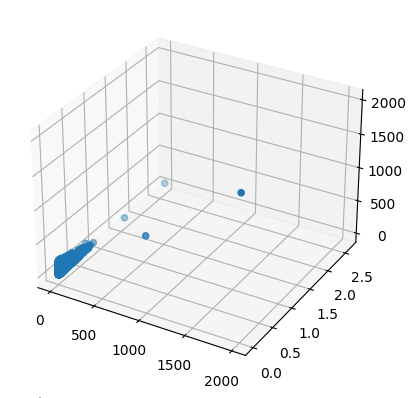

In [10]:
#fig = pyplot.figure(figsize = (6, 6))
ax = pyplot.axes(projection = '3d')
ax.scatter(  new_data_vector["ETA"],new_data_vector["P"],new_data_vector["nTracks"],)
# Print the chart
pyplot.show()

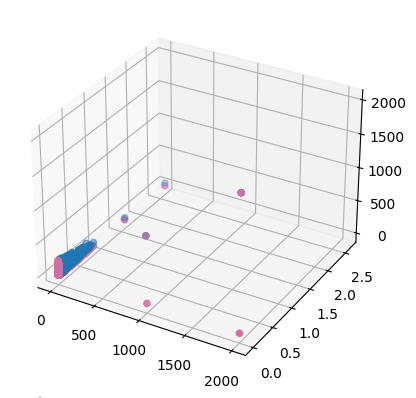

In [11]:
#fig = pyplot.figure(figsize = (6, 6))
ax = pyplot.axes(projection = '3d')
ax.scatter(  new_data_vector["ETA"] >=50,new_data_vector["P"],new_data_vector["nTracks"]>=2,color="#d46f9f")
ax.scatter(  new_data_vector["ETA"],new_data_vector["P"] >= 50,new_data_vector["nTracks"],color="#d46f9f")
ax.scatter(  new_data_vector["ETA"],new_data_vector["P"],new_data_vector["nTracks"]>=2,color="#d46f9f")
ax.scatter(  new_data_vector["ETA"],new_data_vector["P"],new_data_vector["nTracks"])

# Print the chart
pyplot.show()

## PCA 

In [12]:
def PCA(input_data):
    """
    Computes a PCA in a given dataset
    - param input_data: Collision detector data in cherenkov ring
    - return V: New subspace created using the highest eigenvectors 
    - return X_prime: Data with dimensions
    - return d: Input data eigenvalues
    - return w: Input data eigenvector
    """
    
    #Computing covariance matrix
    cov_matrix = torch.cov(input_data)
    
    #Computing eigenvectors & eigenvalues for covariance matrix
    d, w = np.linalg.eigh(cov_matrix)
    d = torch.tensor(d)
    w = torch.tensor(w)
    
    #Sorting eigenvalues in descending order
    sort_d, idx = torch.sort(d, descending = True)

    #Grabing eigenvectors of the two highest eigenvalues
    v1 = w[idx[0]]
    v2 = w[idx[1]]
    
    #Creating subspace V
    V = torch.stack((v1,v2), 1)
    
    #Computing input data mean and sustracting it to the data
    mean = torch.mean(input_data, dim = 0)
    X_mean_sustracted = input_data - mean
    
    #Computing projection using V*Vt*u
    Vt = torch.transpose(V, dim0 = 1, dim1 = 0)
    V_Vt = V.mm(Vt)
    Xp_proj = V_Vt.mm(X_mean_sustracted)
    
    #Computing dimensionality reduction using u' = Vt*u
    Vt = torch.transpose(V, dim0 = 1, dim1 = 0)
    X_prime = Vt.mm(Xp_proj)
    
    #Returning subspace V, data with dimensionality reduced,
    #eigenvalues and eigenvector
    return V, X_prime, d, w

In [13]:
torch_tensor = torch.tensor(new_data_vector.values).transpose(0,1)
#print(torch_tensor)
#cov_matrix = torch.cov(torch_tensor)

V, X_prime, d, w = PCA(torch_tensor)

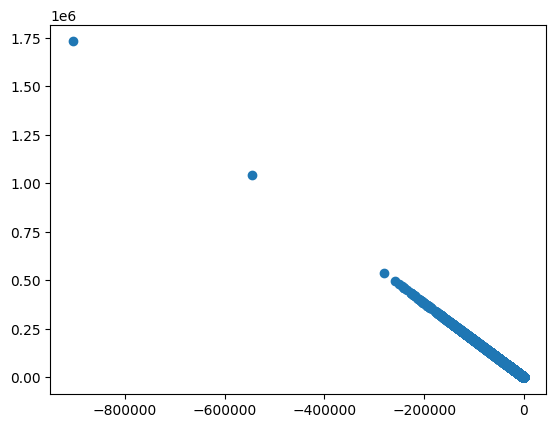

In [14]:
ax = pyplot.axes()
ax.scatter( X_prime[0], X_prime[1])
pyplot.show()

## Data for second stage

In [15]:
df = pd.read_csv("data/kaon_-_down_2016_.csv", sep = "\t", header=1)
in_data_labels = df[["Brunel_P", "Brunel_ETA", "nTracks_Brunel"]].to_numpy()
in_data_data = df[["P", "ETA", "nTracks"]].to_numpy()
model_input_data = torch.tensor(df[["P", "ETA", "nTracks"]].values, dtype=torch.float64).transpose(0,1)

model_input_labels = torch.tensor(df[["Brunel_P", "Brunel_ETA", "nTracks_Brunel"]].values).transpose(0,1)


## Self made metric

In [16]:
def info_lost(in_data, d, w):
    """
    The eigenvector which corresponds to the smallest eigenvalue
    is the informatio that gets lost when the dimensionality is
    reduced. The metric for the loss is multiplying the dataset 
    by the smalles eigenvector and then getting its mean
    - param in_data: Collision detector data in cherenkov ring
    - param d: Input data eigenvalues
    - param w: Input data eigenvector
    return: None
    """
    
    #Sorting eigenvalues in ascending order, getting the smallest 
    #multiplying it by the dataset
    sort_d, idx = torch.sort(d)
    
    small_v = (w[idx[0]].reshape(1,-1))
    Loss = small_v.mm((in_data))
    mean = torch.mean(Loss)
    
    #Printing info loss percentage
    print("Information percentage loss is {} %".format(round(mean.item()/100, 2)))

In [17]:
info_lost(model_input_data.float(), d.float(), w.float())

Information percentage loss is 0.57 %


In [18]:
def L1_norm(data_training, test_observation):
    #Computing Manhattan norm between observation
    #point and samples
    diff_vector = data_training - test_observation
    diff_abs = torch.abs(diff_vector)
    dist = torch.sum(diff_abs, dim=1) 
    return dist

def L2_norm(data_training, test_observation):
    #Computing Euclidean norm between observation
    #point and samples    
    diff_vector = data_training - test_observation
    diff_pow = torch.pow(diff_vector, 2)
    dist = torch.sqrt(torch.sum(diff_pow, dim=1))
    return dist

def Linf_norm(data_training, test_observation):
    #Computing Infinite norm between observation
    #point and samples    
    diff_vector = data_training - test_observation
    diff_abs = torch.abs(diff_vector)
    dist,_ = torch.max(diff_abs, 1)
    return dist

def evaluate_k_nearest_neighbors_observation(data_training, labels_training, test_observation, K = 3, p = 2):
    
    #Choose desired distance and obtain it
    if p == 1:
        dist = L1_norm(data_training, test_observation)
    elif p == 2:
        dist = L2_norm(data_training, test_observation)
    elif p == torch.inf:
        dist = Linf_norm(data_training, test_observation)
    
    #Extracting the t train labels
    t_labels = labels_training[:,0]
    
    #Sorting the distance values and getting
    #their indexes
    sort,index = torch.sort(dist, 0)
    
    #Getting the K Nearest Neighbors
    idx = index[:K]
    K_NN = torch.index_select(t_labels, 0, idx)
    
    #Computing estimation
    t_estimated,_ = torch.mode(K_NN, 0)
    
    #Returning estimation
    return t_estimated
    
def evaluate_k_nearest_neighbors_test_dataset(data_training, labels_training, test_dataset, K, p):
    #Creating a list to store the estimations
    tensor_list = []
    print("test_dataset")

    print(test_dataset)
    #Computing the estimation for the dataset
    for i in range(test_dataset.size(dim = 0)):
        t_estimated = evaluate_k_nearest_neighbors_observation(data_training,labels_training,test_dataset[i,:],K,p)
        tensor_list.append(t_estimated)
        
    #Creating a tensor with all the estimations    
    test_estimations_all = torch.tensor(tensor_list)
    
    return test_estimations_all

def calculate_accuracy(test_estimations, test_labels):
    #Comparing the 2 tensors and getting how many of the
    #entries are equal
    comp = torch.eq(test_estimations,test_labels)
    
    #Counting how mathces there are
    frequency = comp.eq(True).sum()
    
    #Computing accuray
    matches = frequency.item()
    total_elem = test_labels.size(dim = 0)
    accuracy = (matches/total_elem)*100
    print("Method has an accuracy of {} %: ".format(accuracy))

In [19]:
import torch
from sklearn.neighbors import NearestNeighbors


def local_reachability_density(model_input_data, k):
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='auto').fit(model_input_data)
    distances, indices = nbrs.kneighbors(model_input_data)

    # Calculamos la densidad de alcance local (LRD)
    lrds = torch.zeros(model_input_data.shape[0])
    for i in range(model_input_data.shape[0]):
        k_distances = torch.tensor(distances[i, 1:], dtype=torch.float)
        lrd_i = torch.reciprocal(torch.mean(k_distances))
        lrds[i] = lrd_i

    return lrds
def delete_outliers(threshold, model_input_data):
    outlier_indices = torch.nonzero(lrds > threshold, as_tuple=False).squeeze()
    data_without_outliers = torch.tensor(np.delete(abs(model_input_data), outlier_indices, axis=0), dtype=torch.float)
    return data_without_outliers

/var/folders/6q/r9rdnbhn63j774vtv515gq8h0000gn/T/ipykernel_39152/3278841534.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_without_outliers = torch.tensor(np.delete(abs(model_input_data), outlier_indices, axis=0), dtype=torch.float)


tensor([[6.4468e+04, 3.3124e+04, 3.3124e+04,  ..., 6.7820e+04, 1.5000e+03,
         2.0000e+03],
        [3.2306e+00, 3.6243e+00, 3.6243e+00,  ..., 4.5638e+00, 1.0000e+03,
         2.0000e+03],
        [4.9000e+01, 5.9000e+01, 5.9000e+01,  ..., 7.3000e+01, 1.0000e+03,
         2.0000e+03]])


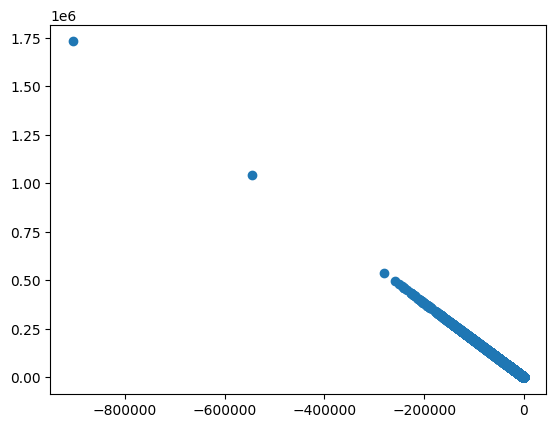

In [20]:
lrds = local_reachability_density(model_input_data, 3)
#Using the gauss belt 2 std grabs around the 95% 
threashold = torch.mean(lrds) + 1*torch.std(lrds)
vector = delete_outliers(threashold, model_input_data)
print(vector)

V2, X_prime2, d2, w2 = PCA(vector)

ax = pyplot.axes()
ax.scatter( X_prime2[0], X_prime2[1])
pyplot.show()

In [21]:
info_lost(model_input_data.float(), d2.float(), w2.float())

Information percentage loss is 0.57 %


In [22]:
import numpy as np
from sklearn.neighbors import NearestNeighbors

def local_reachability_density(X, k):
    X = np.asarray(X)
    n = X.shape[0]
    
    # Compute k-nearest neighbors for each point
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='auto').fit(X)
    distances, indices = nbrs.kneighbors(X)
    
    # Compute reachability distance for each point
    reachability = np.zeros((n, k))
    ones = np.ones((k, k))
    for i in range(n):
        reach_dist = np.maximum(np.vstack((distances[indices[i], 1:], distances[i, indices[i, 1:]])), ones[1:])
        reachability[i] = np.max(reach_dist, axis=0)
    
    # Compute local reachability density for each point
    lrd = 1. / (np.sum(reachability, axis=1) / k)
    
    return lrd


In [23]:
import numpy as np
from sklearn.neighbors import NearestNeighbors

def local_outlier_factor(X, k):
    X = np.asarray(X)
    n = X.shape[0]
    
    # Compute k-nearest neighbors for each point
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='auto').fit(X)
    distances, indices = nbrs.kneighbors(X)
    
    # Compute reachability distance for each point
    reachability = np.zeros((n, k))
    ones = np.ones((k, k))
    for i in range(n):
        r = distances[indices[i], 1:]
        r = np.maximum(np.vstack((r, distances[i, indices[i, 1:]])), ones[1:])
        reachability[i] = np.max(r, axis=0)
    
    # Compute local reachability density for each point
    lrd = 1. / (np.sum(reachability, axis=1) / k)
    
    # Compute local outlier factor for each point
    lrd_mat = lrd[indices]
    lrd_sum = np.sum(lrd_mat, axis=1)
    lof = lrd_sum / (k * lrd)
    
    return lof
